In [10]:
import duckdb

conn = duckdb.connect("data/data.db")

query = """
select
    video_id,
    cluster_id,
    count(*)
from scene
group by 1,2
"""

df = conn.sql(query).df()
df

,video_id,cluster_id,count_star()
0,2645977e-c87f-4a99-9200-7c69e3bf9fc0,0,6
1,b4ce8b0b-04e6-47d5-aa2a-2cbc70b67daa,1,12
2,b4ce8b0b-04e6-47d5-aa2a-2cbc70b67daa,0,2
3,2645977e-c87f-4a99-9200-7c69e3bf9fc0,1,1


[215, 465, 675, 1880, 2000, 2130, 2255, 3185, 3370, 3480, 3615, 4212]
[4212]
3     1205
7      930
11     597
1      250
0      215
2      210
8      185
10     135
5      130
6      125
4      120
9      110
Name: count, dtype: int64


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

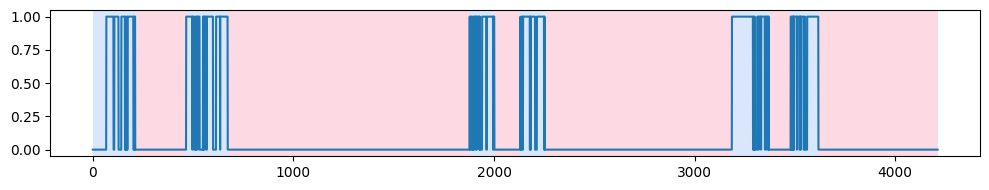

In [6]:
import numpy as np
import ruptures as rpt
import pandas as pd
import plotly.express as px
from scipy.ndimage import binary_opening, binary_closing

max_frame = df['video_frame_index'].max()
min_frame = df['video_frame_index'].min()
n_frames = max_frame + 1

clusters = df['cluster_id'].unique()

cluster_signals = {
    int(cluster_id): np.zeros(n_frames, dtype=np.uint8) for cluster_id in clusters
}

cluster_breakpoints = {}
bucket_labels = {}

for cluster_id, group in df.groupby("cluster_id"):
    cluster_signals[cluster_id][group["video_frame_index"].values] = 1

    signal = cluster_signals[cluster_id]
    
    # smooth flickers in signal signal
    smoothed = binary_closing(signal, structure=np.ones(10))
    smoothed = binary_opening(smoothed, structure=np.ones(10))
    

    algo = rpt.Pelt(model="l2", min_size=100).fit(smoothed)
    breakpoints = algo.predict(pen=20)
    
    min_length = 150
    filtered_cps = [cp for i, cp in enumerate(breakpoints)
                if i == 0 or (cp - breakpoints[i-1]) > min_length]
    cluster_breakpoints[cluster_id] = breakpoints
    print(breakpoints)
    
    labels = np.full_like(signal, fill_value=-1, dtype=np.int8)  # or use None or np.nan if preferred
    bucket = 0
    bp_idx = 0

    prev = 0
    curr = 0
    curr_label = 0
    
    for breakpoint in breakpoints:
        curr = breakpoint
        
        labels[prev:curr] = curr_label
        
        prev = breakpoint
        curr_label += 1
    
    bucket_labels[cluster_id] = labels[labels != -1]

PERSON_ID = 0

print(pd.Series(bucket_labels[PERSON_ID]).value_counts())
rpt.display(cluster_signals[PERSON_ID], cluster_breakpoints[PERSON_ID])

In [ ]:
import pandas as pd

person_1 = df[df['cluster_id'] == PERSON_ID]
person_1 = person_1.merge(
    pd.DataFrame({
        "appearance_bucket": bucket_labels[PERSON_ID],
        "signal": cluster_signals[PERSON_ID]
    }),
    how="left",
    left_on="video_frame_index",
    right_index=True
)
# get interarrival times
person_1['iat'] = person_1['timestamp_ms'].diff().fillna(0)

# normalize iat per bucket
person_1['iat_norm'] = person_1.groupby('appearance_bucket')['iat'].transform(
    lambda x: (x + 1e-3) / (x.sum() + 1e-6)
)

person_1 = person_1.groupby('appearance_bucket').filter(lambda g: g['signal'].sum() > 10)

# sample person_1 to prioritize sparser samples
STRATIFIED_SAMPLE_K = 100

person_1 = (
    person_1
    .sort_values('iat_norm', ascending=False)
    .groupby('appearance_bucket')
    .head(STRATIFIED_SAMPLE_K)
    .sort_values('video_frame_index')
)
person_1.head()

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

# higher energy = more change
# this is like a non-parametric version of KL divergence
# we could also do a gaussian KDE and then measure residuals but this requires no
# model training >:)

def energy_distance_cosine(X: np.ndarray, Y: np.ndarray):
    N, M = len(X), len(Y)
    cross = np.sum(cdist(X, Y, metric="cosine")) / (N * M)
    xx = np.sum(cdist(X, X, metric="cosine")) / (N * N)
    yy = np.sum(cdist(Y, Y, metric='cosine')) / (M * M)
    return 2 * cross - xx - yy

person_1['clip_pca_50'] = PCA(n_components=50).fit_transform(person_1['clip_embedding'].to_list()).tolist()

appearance_buckets = []
appearance_matrices = []
distances = [0]

for appearance_bucket, dff in person_1.groupby('appearance_bucket'):
    appearance_buckets.append(appearance_bucket)
    appearance_matrices.append(np.stack(dff['clip_pca_50'].to_list()))

for i in range(1, len(appearance_buckets)):
    curr = appearance_matrices[i]
    prev = appearance_matrices[i-1]
    distances.append(energy_distance_cosine(curr, prev))

print([i.size for i in appearance_matrices])
print(len(appearance_buckets), len(distances))
print([float(round(i, 3)) for i in distances])

In [ ]:
THRESHOLD = 0.48

anomalies = {b: bool(distance > THRESHOLD) for b, distance in zip(appearance_buckets, distances)}
person_1['is_anomaly'] = person_1['appearance_bucket'].map(anomalies)
print(anomalies)
person_1.head()